# Testing the Neural Network

In this file, I will perform a couple of tests to see the limits of the network and how useful it would be.

In order to test, I will assume that the input will have maximum depth 9, because we didn't train the network on larger depths.

I consider that you can transform a solved cube in a different configuration, for example to create a mosaic, or transform a different configuration into a solved cube.

## 1. Creating useful functions

Here, I am creating functions that will be necessary to perform the tests.

In [3]:
# importing the necessary libraries and models
import numpy as np
from cube import *
import tensorflow as tf
import pandas as pd
import random

model = tf.keras.models.load_model('saved_model/my_model')

In [4]:
# function to get the prediction of depth of any cube
def get_depth(cube):
    # flattening
    flattened_cube_combination = np.array(cube).flatten()

    X = np.zeros(shape=(1,54))
    X[0] = flattened_cube_combination

    prediction = model.predict(x=X).argmax(axis=1)[0]

    return prediction

# list with all moviment functions
move_func = [["right", right], ["right_inverse", right_inverse], ["left", left], ["left_inverse", left_inverse], 
            ["back", back], ["back_inverse", back_inverse], ["front", front], ["front_inverse", front_inverse], 
            ["down", down], ["down_inverse", down_inverse], ["up", up], ["up_inverse", up_inverse],
            ["static", static]]

# function to find all moviments to solve the problem
def get_movements(cube):
    magic = [ [i for _ in range(9)] for i in range(6) ]
    cube_combination = [ [ cube[i][j] for j in range(9)] for i in range(6) ]
    # loop to find the moviments
    movements = []

    for i in range(12):
        best = float("inf")
        move = []
        for i in range(len(move_func)):
            new_cube = move_func[i][1](cube_combination)

            # checking if it was solved and returning all movements to get there
            if new_cube == magic:
                move = move_func[i]
                movements.append(move)
                return movements

            depth = get_depth(new_cube)
            if best > depth:
                best = depth
                move = move_func[i]

        cube_combination = move[1](cube_combination)
        movements.append(move)
    
    # if can't find solution after 12 movement trials
    return False

In [6]:
# testing
cube_combination_4 = [[3, 3, 3, 0, 0, 0, 3, 3, 3],
                    [2, 2, 2, 1, 1, 1, 2, 2, 2],
                    [4, 4, 4, 0, 2, 0, 5, 5, 5],
                    [4, 4, 4, 1, 3, 1, 5, 5, 5],
                    [1, 4, 0, 3, 4, 2, 1, 4, 0],
                    [1, 5, 0, 3, 5, 2, 1, 5, 0]]

get_movements(cube_combination_4)

[['back', <function cube.back(cube)>],
 ['front', <function cube.front(cube)>],
 ['right_inverse', <function cube.right_inverse(cube)>],
 ['left', <function cube.left(cube)>]]

In [7]:
cube_combination_9 = [[0, 2, 1, 4, 0, 5, 3, 1, 5],
                    [5, 3, 1, 2, 1, 3, 2, 2, 0],
                    [2, 4, 1, 5, 2, 3, 5, 5, 3],
                    [1, 5, 0, 2, 3, 4, 4, 1, 0],
                    [4, 3, 2, 1, 4, 0, 3, 0, 4],
                    [5, 0, 2, 0, 5, 4, 3, 1, 4]]

get_movements(cube_combination_9)

False

## 2. Creating random cubes for test

I am going to create random cubes with each amount of depth to see if it can actually solve or not. All the results will be stored in a dataframe so I can plot and see the improvements.

In [40]:
# creating brand new Rubik's cube
magic = [ [i for _ in range(9)] for i in range(6) ]

columns = [ 'cube_'+str(layer)+'_'+str(cubie) for layer in range(6) for cubie in range(9)]

columns.append("depth")

df_test = pd.DataFrame(columns = columns)

for i in range(1,10):
    for j in range(100):
        new_cube = [ [i for _ in range(9)] for i in range(6) ]
        for k in range(i):
            new_cube = random.choice(move_func)[1](new_cube)

        arr = np.array(new_cube).flatten()
        arr = np.append(arr, i)
        df = pd.DataFrame(arr.reshape(1,-1), columns = columns)
        df_test = df_test.append(df, ignore_index=True)

In [41]:
print(len(df_test))
df_test["depth"].sample(n=10)

900


264    3
388    4
323    4
794    8
57     1
319    4
210    3
459    5
36     1
527    6
Name: depth, dtype: object

## 3. Testing each random cube and storing on the dataset

After getting the results, I will store if it was possible to solve and how many moviments.

In [42]:
columns = [ 'cube_'+str(layer)+'_'+str(cubie) for layer in range(6) for cubie in range(9)]
cubes = []
for index, row in df_test.iterrows():
    flatten_cube = row[columns].values
    cube = np.reshape(flatten_cube, (6,9))
    cubes.append(cube)

solved = []
n_move = []

for i in range(len(cubes)):
    movements = get_movements(cubes[i])

    if movements == False:
        solved.append(False)
        n_move.append(None)

    else:
        solved.append(True)
        n_move.append(len(movements))

df_test["solved"] = solved
df_test["n_move"] = n_move

## 4. Exploring the results

Here, I will plot some data to see how good is the neural network.

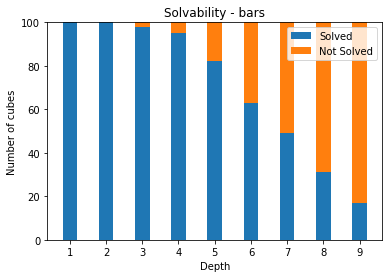

In [54]:
import matplotlib.pyplot as plt 
  
X = [i for i in range(1, 10)]
y_solved = [df_test[df_test["depth"] == i]["solved"].sum() for i in range(1,10)]
y_not_solved = [ 100-y_solved[i] for i in range(9)]
  
plt.bar(X, y_solved, 0.4, label = 'Solved')
plt.bar(X, y_not_solved, 0.4, label = 'Not Solved', bottom=y_solved)
  
plt.xticks(X)
plt.xlabel("Depth")
plt.ylabel("Number of cubes")
plt.title("Solvability - bars")
plt.legend()
plt.savefig('solvability-bars.png')
plt.show()

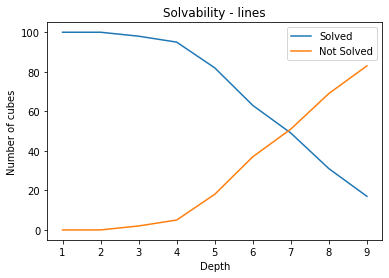

In [55]:
plt.plot(X, y_solved, label = 'Solved')
plt.plot(X, y_not_solved, label = 'Not Solved')
  
plt.xticks(X)
plt.xlabel("Depth")
plt.ylabel("Number of cubes")
plt.title("Solvability - lines")
plt.legend()
plt.savefig('solvability-lines.png')
plt.show()

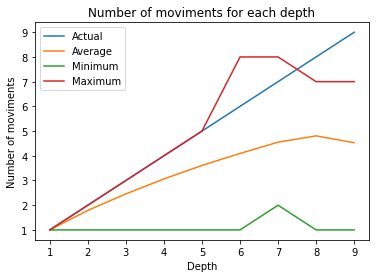

In [56]:
y_avg_moviments = [df_test[df_test["depth"] == i]["n_move"].mean(axis = 0, skipna = True) for i in range(1,10)]

y_min_moviments = [df_test[df_test["depth"] == i]["n_move"].dropna().min() for i in range(1,10)]

y_max_moviments = [df_test[df_test["depth"] == i]["n_move"].dropna().max() for i in range(1,10)]

plt.plot(X, X, label = 'Actual')
plt.plot(X, y_avg_moviments, label = 'Average')
plt.plot(X, y_min_moviments, label = 'Minimum')
plt.plot(X, y_max_moviments, label = 'Maximum')
  
plt.xticks(X)
plt.xlabel("Depth")
plt.ylabel("Number of moviments")
plt.title("Number of moviments for each depth")
plt.legend()
plt.savefig('moves-per-depth.png')
plt.show()

## 5. Creating a cube for Mario Bros' mosaic

![Mosaic](mario_mosaic.png)

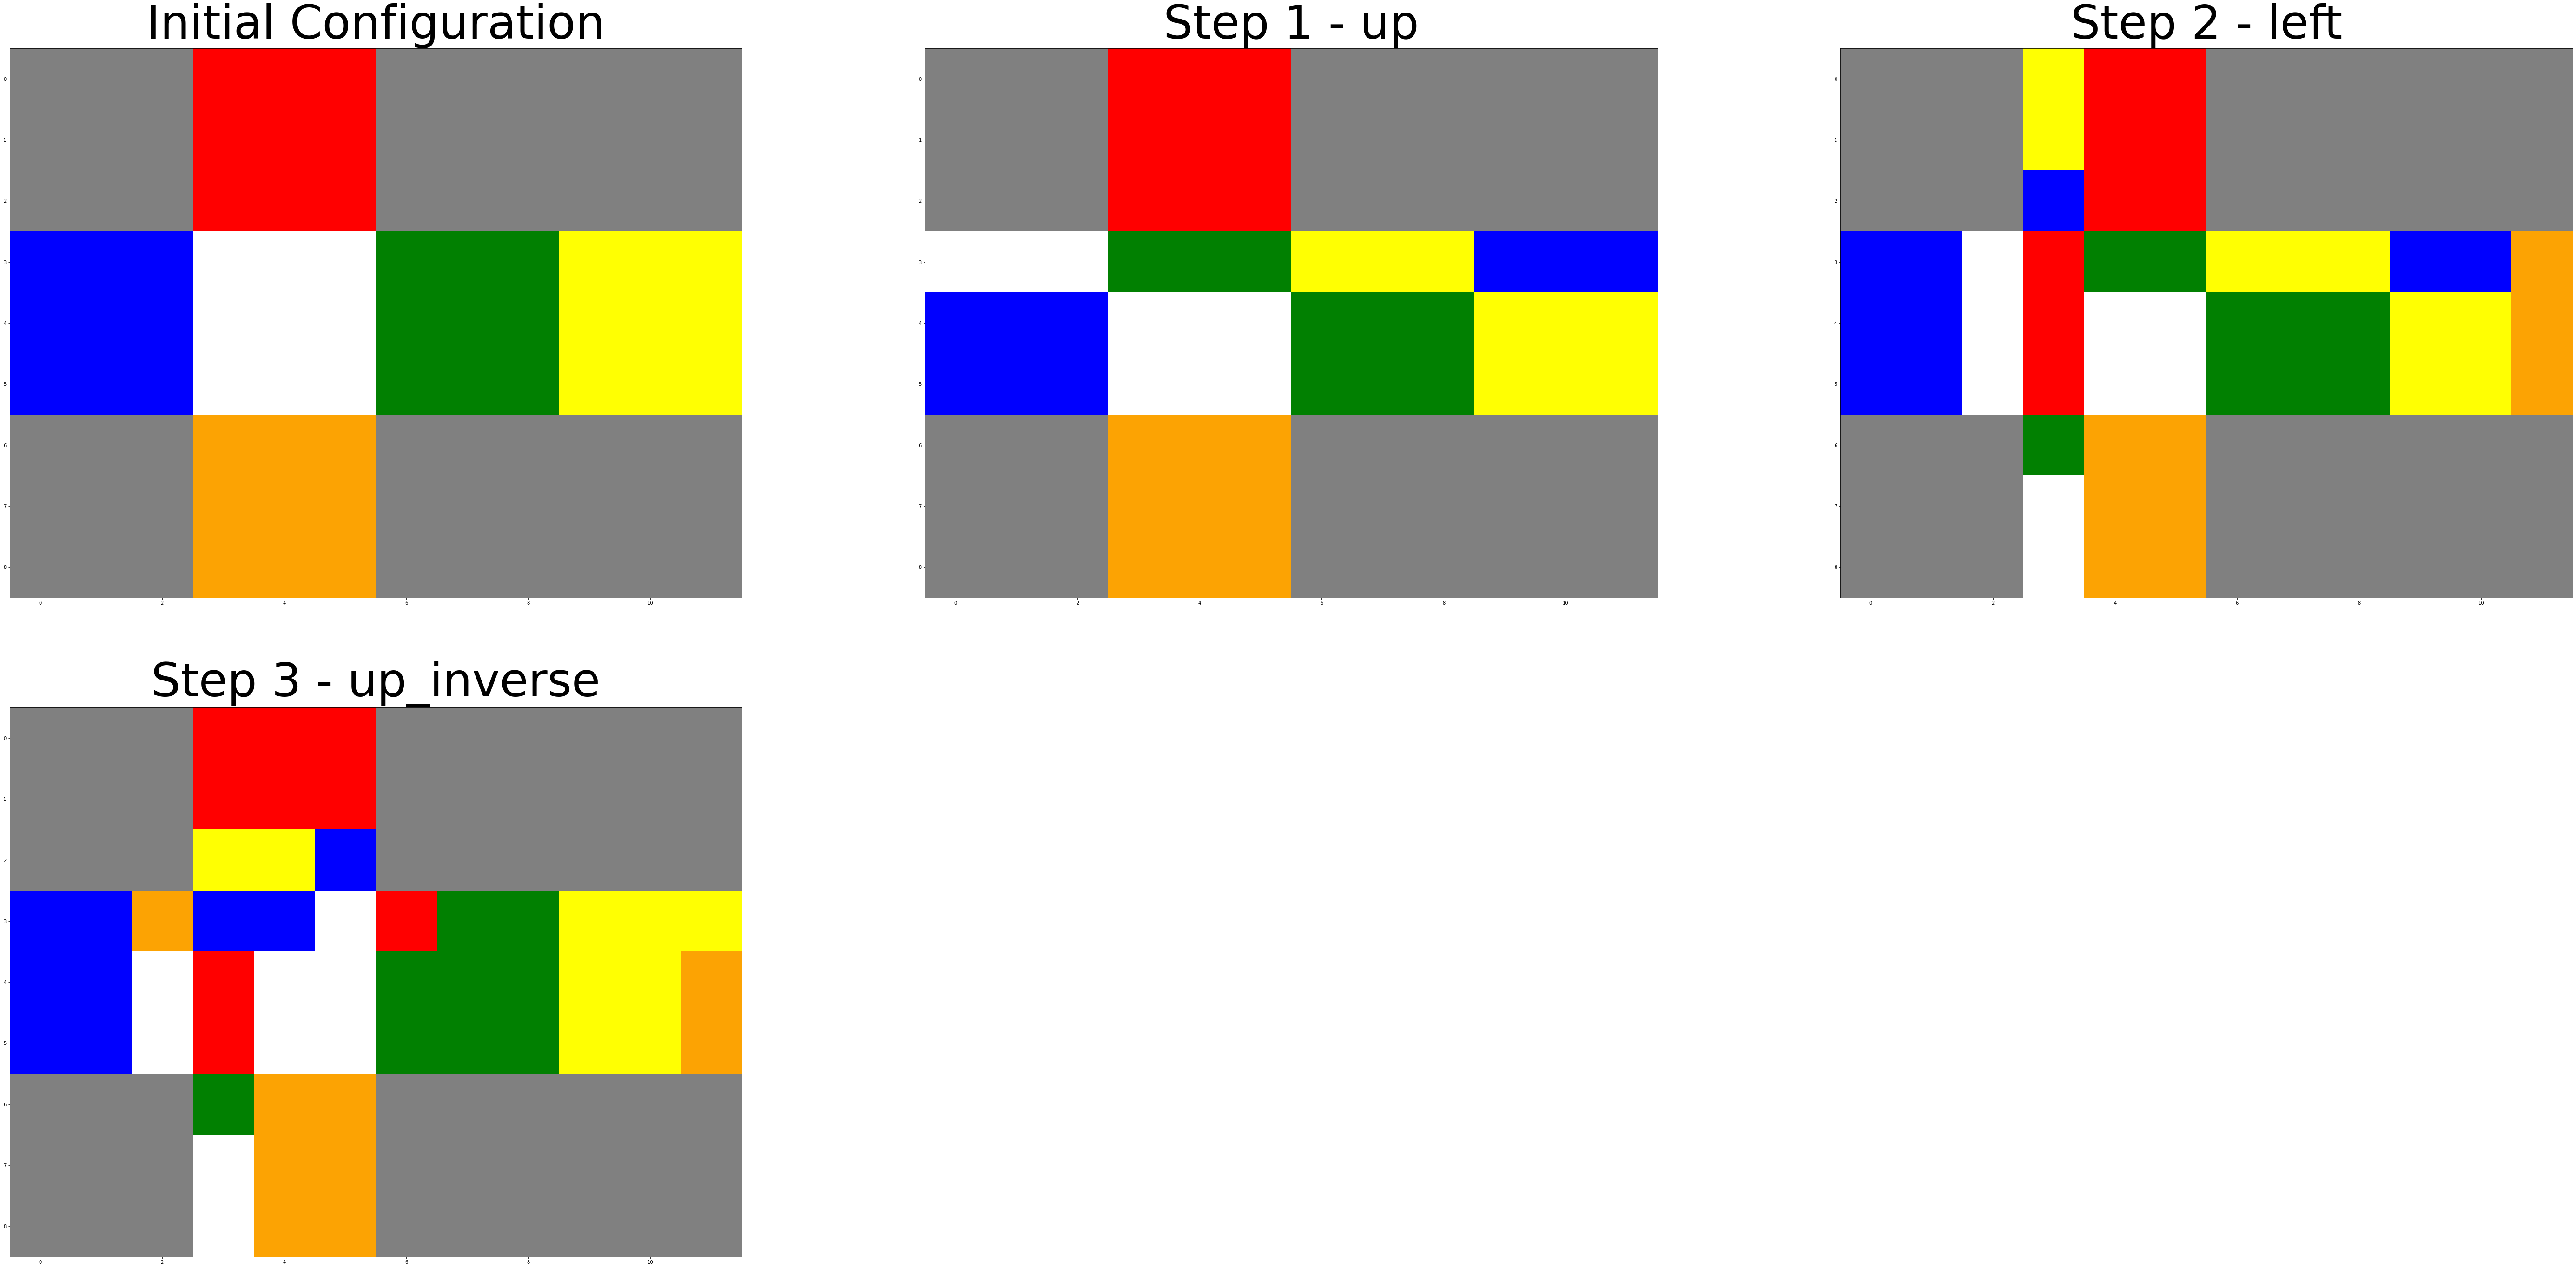

In [16]:
# configuration we want
mario_cube= [[0, 0, 0, 3, 0, 0, 3, 0, 0],
            [1, 4, 4, 1, 1, 2, 1, 1, 2],
            [0, 0, 4, 2, 2, 2, 2, 2, 2],
            [1, 3, 3, 1, 3, 3, 5, 3, 3],
            [3, 4, 4, 1, 4, 4, 1, 4, 4],
            [5, 5, 2, 5, 5, 5, 5, 5, 5]]

# original configuration
magic = [ [i for _ in range(9)] for i in range(6) ]

moves = get_movements(mario_cube)

moves = moves[::-1]

plt.figure(figsize=(100,100))

for i in range(len(moves)):
    if i==0:
        plt.subplot(4, 3, i+1)
        create_cube_visualization(magic)
        plt.title("Initial Configuration", fontsize = 100)
    plt.subplot(4, 3, i+2)
    magic = moves[i][1](magic)
    create_cube_visualization(magic)
    plt.title("Step {0} - {1}".format(i+1, moves[i][0]), fontsize = 100)
    
plt.savefig('mario_moves.png')
plt.show()